# Development of Emotion and Reasoning in the General Speeches of the United Nations: A text-based machine learning approach
## Script 2: Figures & Tables
### Author: Sarah Franzen

Run Script 0 and 1 beforehand in order to create the proper folder structure and implement the data.

### Description: 
#### This file creates the following figures

Descriptive Figures
- Frequency of speeches by year
- Frequency of speeches by country
- Longest and Shortest Speeches by Word Count
- Share of female and male speakers
- Share of position by speakers

Result Figures
- Emotionaliy over time (Overall)
- Emotionality over time  by permanent Security Council Membership
- Emotionality over time  by permanent Security Council Members
- Emotionality over time  by Gender
- Emotionality over time  by English as official language
- Emotionality over time  by Position
- Cosine Similarity of Corpus Words to the Centorids

Additional Figures
- Emotionality over time (Individual Stopwords List)
- Emotionality over time (Excluding low frequency words for weighting)

### Set Up & Load Data

In [89]:
# == Import libraries for data processing and visualization ==
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import joblib
import pandas as pd
from scipy import stats
from tabulate import tabulate
import textwrap
from matplotlib.lines import Line2D
from gensim.models import Word2Vec
from wordcloud import WordCloud
import random
from scipy.spatial.distance import cosine
import numpy as np

# === Set Working Directory ===

# Prompt user to enter working directory path
#wd = input("Please enter your working directory path (e.g., C:\\Users\\sarah\\OneDrive\\Dokumente\\Masterarbeit): ").strip()

# Change to the entered working directory
#try:
   # os.chdir(wd)
    #print(f"Working directory set to: {os.getcwd()}")
#except FileNotFoundError:
   # print("ERROR: The directory you entered does not exist. Please restart and enter a valid path.")
    #exit(1)

# Set your working directory (adjust this as needed)
#wd = r"C:\Users\sarah\OneDrive\Dokumente\Masterarbeit"
wd = Path(r"C:\Users\sarah\OneDrive\Dokumente\Masterarbeit")

# === Define Folder Paths ===

data_c = wd / 'data'
data_results = data_c / 'results'
data_temp = data_c / 'temp'
data_freq = data_c / 'freq'
data_dict = data_c / 'dictionaries'
fig_dir = wd / 'fig'
data_models = data_c / 'models'

# === Load data ===
os.chdir(data_results)
un_corpus_scored = pd.read_csv(
    os.path.join(data_results, "un_corpus_scored.csv"),
    sep=';', 
    encoding='utf-8'
)

ind_stopwords_un_corpus_scored = pd.read_csv(
    os.path.join(data_results, "ind_stopwords_un_corpus_scored.csv"),
    sep=';', 
    encoding='utf-8'
)

removed_lowfreq_words_un_corpus_scored = pd.read_csv(
   os.path.join(data_results, "removed_lowfreq_words_un_corpus_scored.csv"),
   sep=';', 
   encoding='utf-8'
)

affect_dic = joblib.load(os.path.join(data_dict, 'dictionary_affect.pkl'))
cognition_dic = joblib.load(os.path.join(data_dict, 'dictionary_cognition.pkl'))

w2v = Word2Vec.load(str(data_models / "w2v-vectors_8_300.pkl"))
word_vectors = w2v.wv

affect_centroid = joblib.load(os.path.join(data_c, 'centroids', 'affect_centroid.pkl'))
cognition_centroid = joblib.load(os.path.join(data_c, 'centroids', 'cog_centroid.pkl'))

stopwords = joblib.load(os.path.join(data_c, "stopwords.pkl"))
procedural_words = joblib.load(os.path.join(data_c, "procedural_words.pkl"))

# == Define Global Plotting Settings ===

FIGSIZE = (12, 6)
LINEWIDTH = 2
MARKER = None

# Grid style
GRID_STYLE = "whitegrid"
sns.set_style(GRID_STYLE)

# X-axis ticks
TICK_YEARS = [1946] + list(range(1950, 2025, 5))
if 2024 not in TICK_YEARS:
    TICK_YEARS.append(2024)
XTICK_ROTATION = 45

# Font sizes
AXIS_LABEL_FONT_SIZE = 14     
TICK_LABEL_FONT_SIZE = 14      
LEGEND_FONT_SIZE = 12         

# Tick Settings 
TICK_LENGTH = 5
TICK_WIDTH = 2
TICK_COLOR = 'black'
TICK_DIRECTION = 'out'

# Y-axis range for primary axis (y1)
Y_RANGE_EMOTIONALITY = (0.5, 1.1)

# Y-axis for second axis (y2)
AX_SET_YLIM = 0
AX_SET_Y_MARGIN = 0
SECOND_Y_AXIS_BOTTOM = 0

# Spines & Grid Lines
SPINE_COLOR = 'darkgrey'
SPINE_WIDTH = 1.5
GRID_COLOR = 'darkgrey'
GRID_WIDTH = 1.0


# Legend settings
LEGEND_LOC = "upper center"
LEGEND_BBOX = (0.5, -0.15)
LEGEND_NCOL = 3     

# Layout
TIGHT_LAYOUT_RECT = [0, 0, 1, 1]

# Despine options
DESPINE_SETTINGS = dict(left=True, right=True, top=True, bottom=False)

# Note
FIG_NOTE_FONT = dict(ha='center', fontsize=14, fontstyle='italic')

# Color Palette
CUSTOM_COLORS = ['#004260', '#50822E', '#f2c80c',
                 #'#F69B2D', 
                 '#E4003A', '#D95F02']

In [90]:
un_corpus_scored.head()

filename                                             speech  \
0  ARG_01_1946.txt  At the resumption of the first session of the ...   
1  AUS_01_1946.txt  The General Assembly of the United Nations is ...   
2  BEL_01_1946.txt  The\tprincipal organs of the United Nations ha...   
3  BLR_01_1946.txt  As more than a year has elapsed since the Unit...   
4  BOL_01_1946.txt  Coming to this platform where so many distingu...   

  country_code  year country_name  speech_length_words  \
0          ARG  1946    Argentina                 3364   
1          AUS  1946    Australia                 4531   
2          BEL  1946      Belgium                 2501   
3          BLR  1946      Belarus                 3055   
4          BOL  1946      Bolivia                 1501   

   english_official_language  security_council_permanent        speaker_name  \
0                          0                           0            Mr. Arce   
1                          0                           0           Mr. Makin   
2                          1                           0  Mr. Van Langenhove   
3                          0                           0         Mr. Kiselev   
4                          0                           0   Mr. Costa du Rels   

  position  gender_dummy      speech_label  \
0      NaN           0.0  Argentina (1946)   
1      NaN           0.0  Australia (1946)   
2      NaN           0.0    Belgium (1946)   
3      NaN           0.0    Belarus (1946)   
4      NaN           0.0    Bolivia (1946)   

                                 speech_preprocessed  \
0  ['resumpt', 'argentin', 'renounc', 'decis', 's...   
1  ['exercis', 'respons', 'charter', 'problem', '...   
2  ['charter', 'respons', 'mainten', 'consider', ...   
3  ['elaps', 'charter', 'san', 'stabl', 'charter'...   
4  ['eloqu', 'preced', 'profit', 'tribut', 'ladi'...   

   speech_length_preprocessed  \
0                         354   
1                         360   
2                         270   
3                         383   
4                         146   

                                        speech_final  speech_length_final  \
0  ['resumpt', 'argentin', 'renounc', 'decis', 's...                  339   
1  ['exercis', 'respons', 'charter', 'problem', '...                  360   
2  ['charter', 'respons', 'mainten', 'consider', ...                  269   
3  ['elaps', 'charter', 'san', 'stabl', 'charter'...                  380   
4  ['eloqu', 'preced', 'profit', 'tribut', 'ladi'...                  142   

   affect_d  cognition_d     score  
0  0.945976     0.618412  0.762908  
1  1.271003     0.607093  0.523364  
2  1.180030     0.683827  0.622996  
3  0.813027     0.798740  0.988106  
4  0.512349     0.567732  1.038668

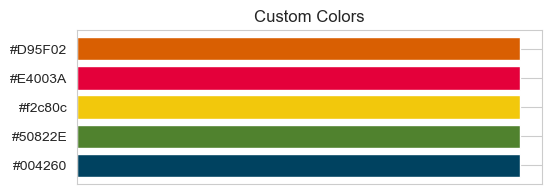

In [91]:
plt.figure(figsize=(6, 2))
for i, color in enumerate(CUSTOM_COLORS):
    plt.barh(y=i, width=1, color=color)
plt.yticks(range(len(CUSTOM_COLORS)), CUSTOM_COLORS)
plt.xticks([])
plt.title("Custom Colors")
plt.show()

## Figures

### Figure: Frequency of speeches by year

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


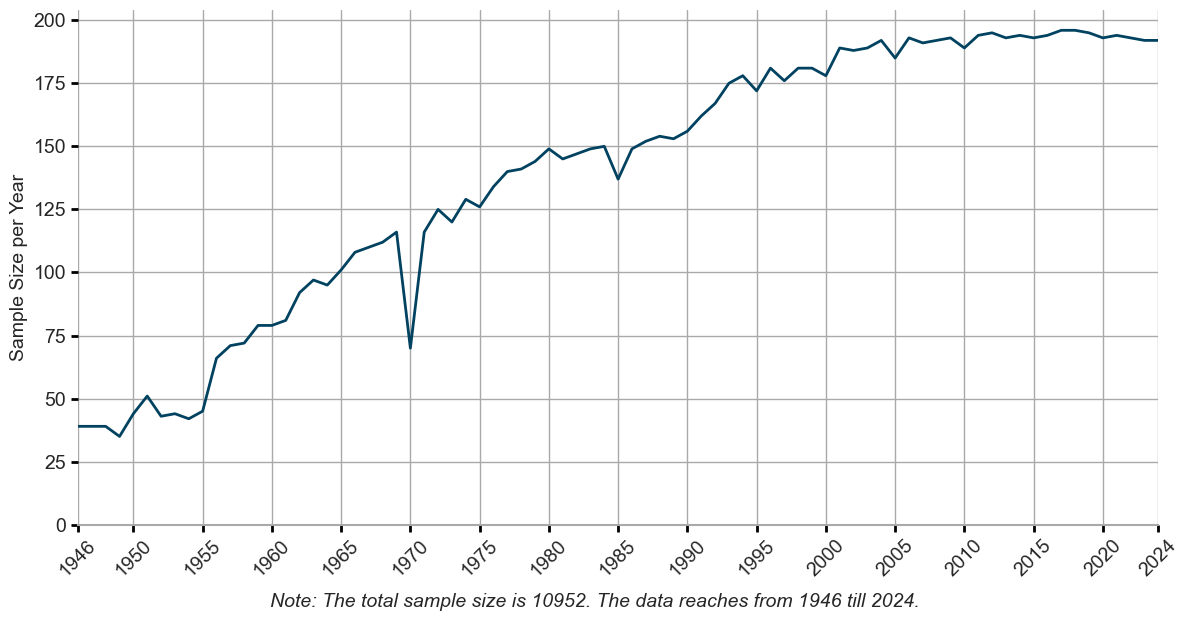

In [94]:
# === Overall Sample Size per Year Plot ===

overall_sample_size_per_year = un_corpus_scored['year'].value_counts().sort_index()
overall_total = overall_sample_size_per_year.sum()

fig, ax = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    x=overall_sample_size_per_year.index,
    y=overall_sample_size_per_year.values,
    marker=MARKER,
    color=CUSTOM_COLORS[0],
    linewidth=LINEWIDTH,
    ax=ax
)

# Labels
ax.set_xlabel("")
ax.set_ylabel("Sample Size per Year", fontsize=AXIS_LABEL_FONT_SIZE)

# Y-axis limits and margins
ax.set_ylim(bottom=AX_SET_YLIM)
ax.margins(y=AX_SET_Y_MARGIN)

# X-axis: fixed range and major ticks
ax.set_xlim(1946, 2024)
ax.set_xticks(TICK_YEARS)
ax.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION)

# Tick parameters — force them to appear
ax.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH, color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH, color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)

# Spines
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['left'].set_linewidth(SPINE_WIDTH)
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grid lines
ax.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

# Despine
sns.despine(**DESPINE_SETTINGS)

# Optional note under the plot
plt.figtext(
    0.5, -0.02,
    f"Note: The total sample size is {overall_total}. The data reaches from 1946 till 2024.",
    **FIG_NOTE_FONT
)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'frequency_by_year.png'), bbox_inches='tight')
plt.show()

# Reset the display option to original
pd.reset_option('display.max_rows')

### Figure: Frequency of speeches by country

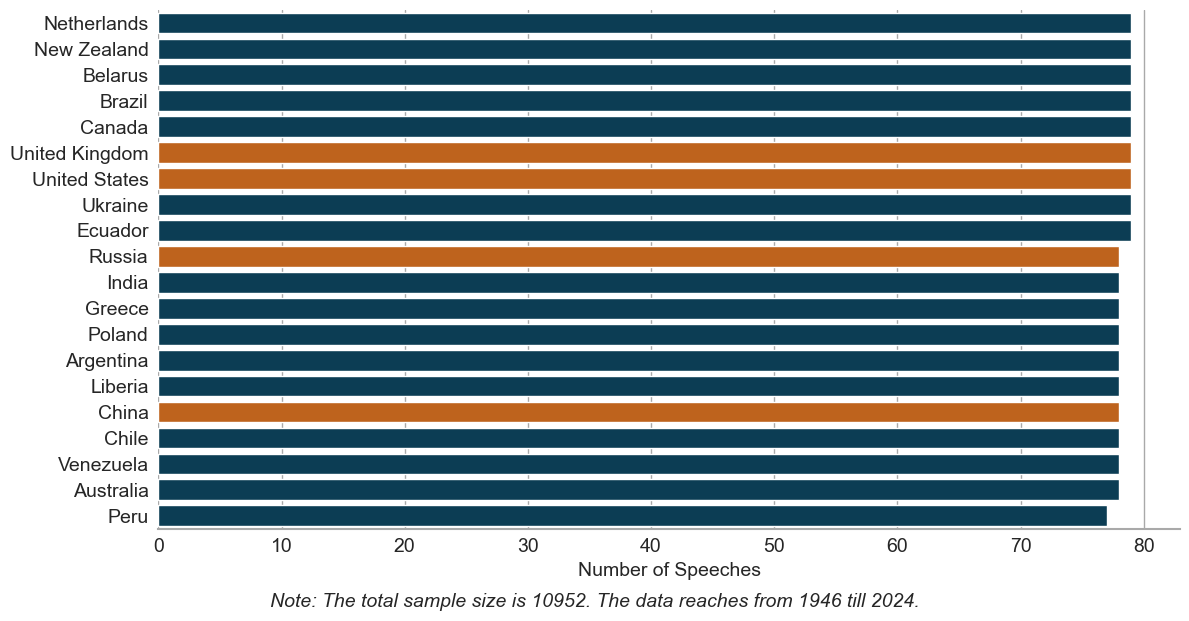

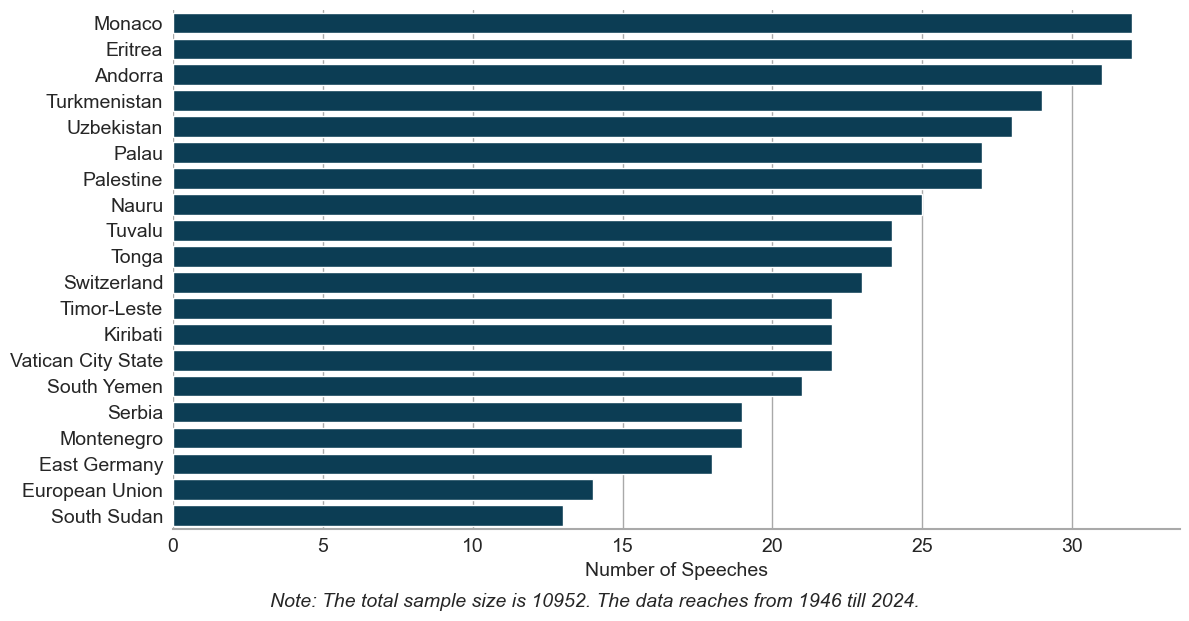

In [96]:
# === Graph 1: Top 20 Countries by Frequency ===

top_countries = un_corpus_scored['country_name'].value_counts().nlargest(20)

# Get security council status for top countries
country_security_status = (
    un_corpus_scored.groupby('country_name')['security_council_permanent']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else 0)
    .reindex(top_countries.index)
)

# Assign colors: orange if permanent member of security council, blue otherwise
colors_barchart_sec_council = ['#D95F02' if status == 1 else '#004260' for status in country_security_status]

plt.figure(figsize=FIGSIZE) 
sns.barplot(x=top_countries.values, y=top_countries.index, palette=colors_barchart_sec_council)

# Axis labels and ticks
plt.xlabel("Number of Speeches", fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel("")
plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)

# Apply global despine settings
sns.despine(**DESPINE_SETTINGS)

# Thicker spines
ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(SPINE_WIDTH)

# Grid lines
ax.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

# Add note below
plt.figtext(
    0.5, -0.02,
    f"Note: The total sample size is {overall_total}. The data reaches from 1946 till 2024.",
    **FIG_NOTE_FONT
)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'top_20_countries_by_frequency.png'), bbox_inches='tight')
plt.show()


# === Graph 2: Bottom 20 Countries by Frequency ===

bottom_countries = un_corpus_scored['country_name'].value_counts().nsmallest(20)
bottom_countries = bottom_countries.sort_values(ascending=False)

plt.figure(figsize=FIGSIZE)
sns.barplot(x=bottom_countries.values, y=bottom_countries.index, color=CUSTOM_COLORS[0])

# Axis labels and ticks
plt.xlabel("Number of Speeches", fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel("")
plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)

# Apply global despine settings
sns.despine(**DESPINE_SETTINGS)

# Thicker spines
ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(SPINE_WIDTH)

# Grid lines
ax.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

# Add note below
plt.figtext(
    0.5, -0.02,
    f"Note: The total sample size is {overall_total}. The data reaches from 1946 till 2024.",
    **FIG_NOTE_FONT
)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'bottom_20_countries_by_frequency.png'), bbox_inches='tight')
plt.show()

### Figure: Length of Speeches over time (BEOFRE PREPROCESSING)

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

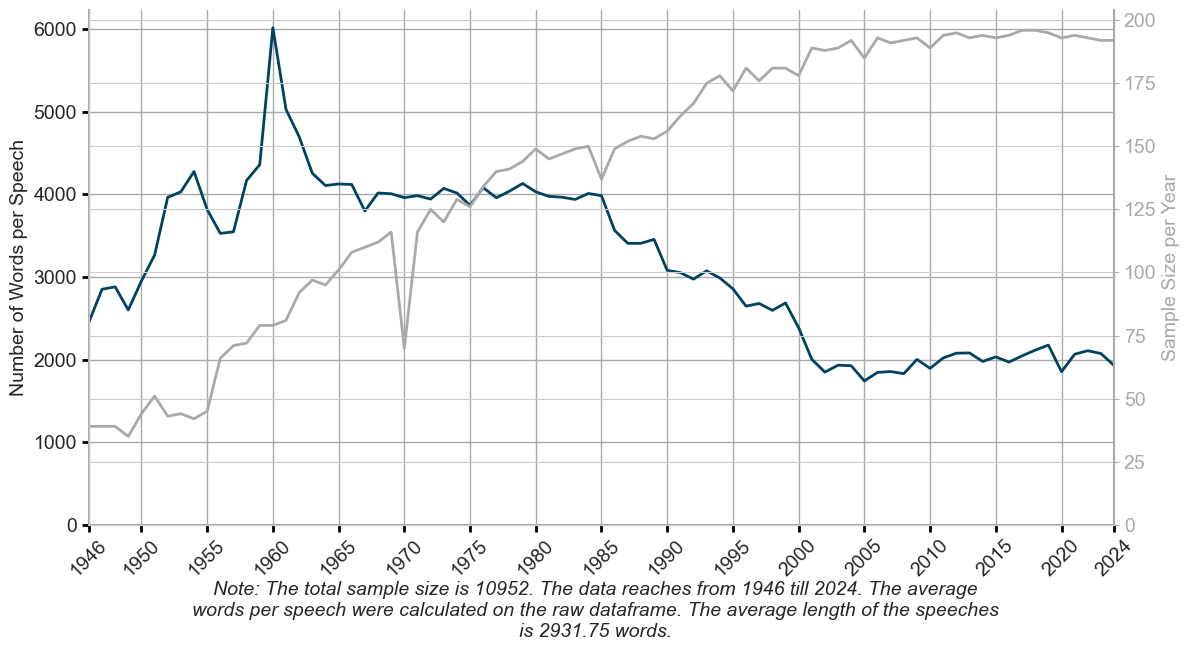

In [98]:
# === Average Speech Length per Year Plot ===

speech_length_words = un_corpus_scored.groupby("year")["speech_length_words"].mean()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    x=speech_length_words.index,
    y=speech_length_words.values,
    color=CUSTOM_COLORS[0], 
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Number of Words per Speech", fontsize=AXIS_LABEL_FONT_SIZE)

ax1.tick_params(labelsize=TICK_LABEL_FONT_SIZE)

ax1.set_ylim(bottom=AX_SET_YLIM)
ax1.margins(y=AX_SET_Y_MARGIN)

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION)

ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH, color=TICK_COLOR
)
ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH, color=TICK_COLOR
)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)

# Grid lines
ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

# === Right y-axis: sample size in dark grey ===
ax2 = ax1.twinx()
sns.lineplot(
    x=overall_sample_size_per_year.index,
    y=overall_sample_size_per_year.values,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', colors='darkgrey', labelsize=TICK_LABEL_FONT_SIZE)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = (
    f"Note: The total sample size is {overall_total}. "
    f"The data reaches from 1946 till 2024. "
    f"The average words per speech were calculated on the raw dataframe. "
    f"The average length of the speeches is 2931.75 words."
)

wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))

plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'speech_length_by_year.png'), bbox_inches='tight')
plt.show()

### Figure: Longest and Shortest Speeches by Word Count (Raw Data)

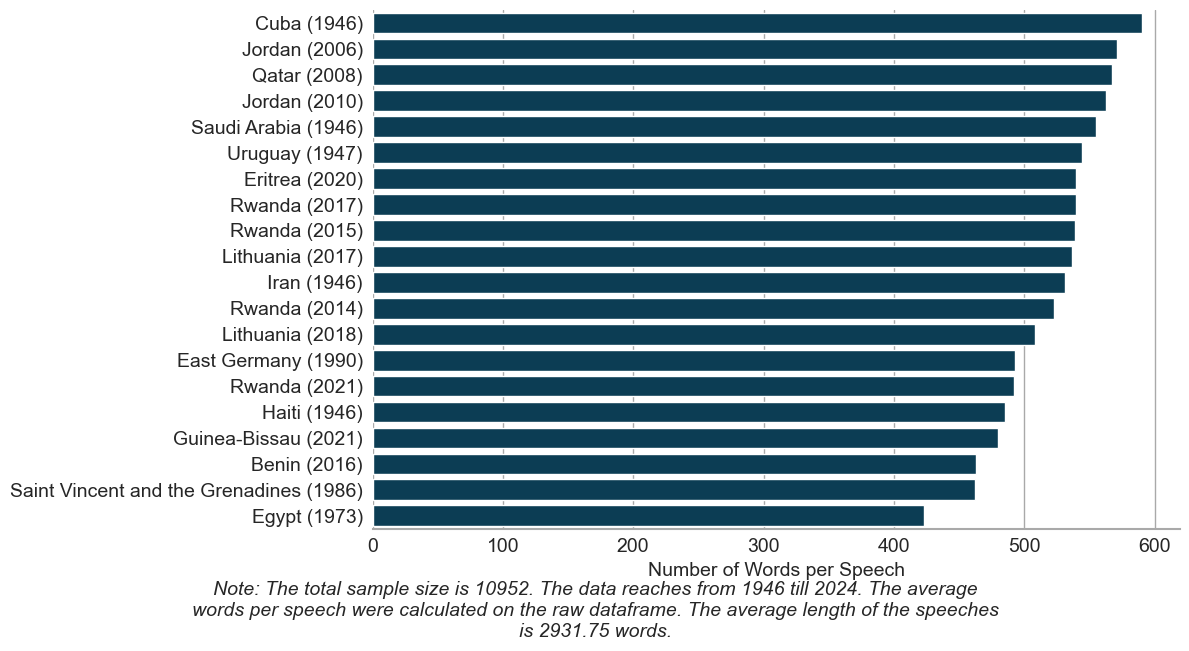

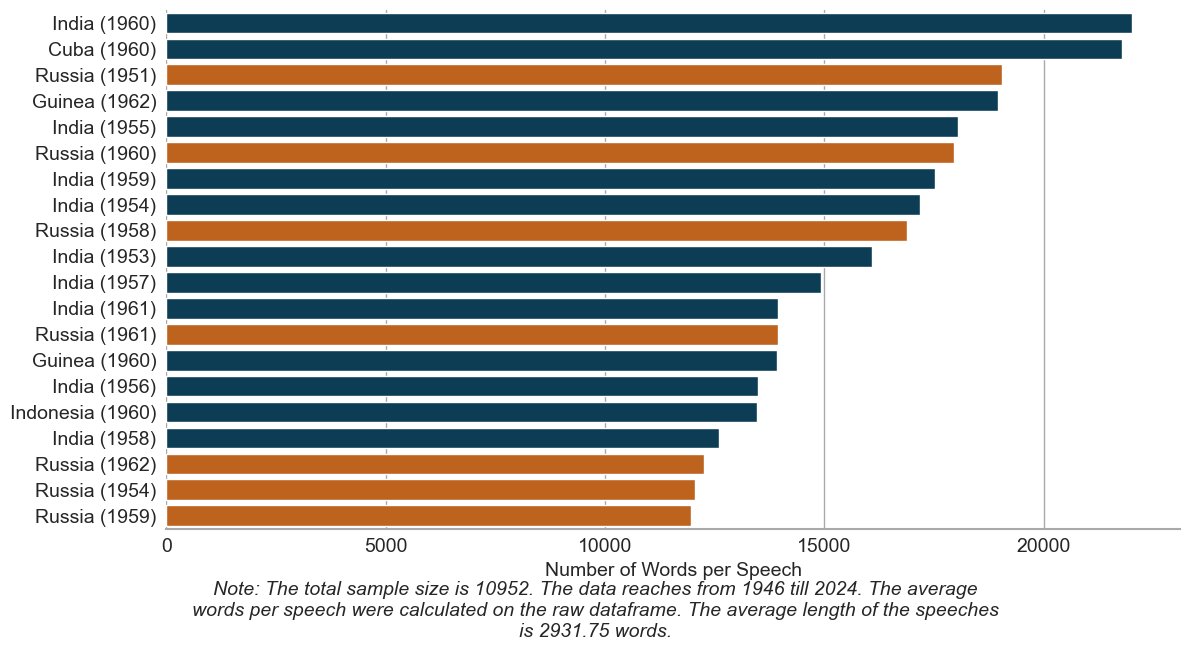

In [100]:
# === Graph 1: 20 Shortest Speeches ===
shortest_speeches = (
    un_corpus_scored.nsmallest(20, 'speech_length_words')
    .sort_values(by='speech_length_words', ascending=False)
    [['speech_label', 'speech_length_words']]
)

plt.figure(figsize=FIGSIZE)
sns.barplot(
    data=shortest_speeches,
    x='speech_length_words',
    y='speech_label',
    color=CUSTOM_COLORS[0] 
)


plt.xlabel("Number of Words per Speech", fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel("")


plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)


ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(SPINE_WIDTH)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

sns.despine(**DESPINE_SETTINGS)
plt.tight_layout(rect=TIGHT_LAYOUT_RECT)

note_text = (
    f"Note: The total sample size is {overall_total}. "
    f"The data reaches from 1946 till 2024. "
    f"The average words per speech were calculated on the raw dataframe. "
    f"The average length of the speeches is 2931.75 words."

)

wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))

plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.savefig(os.path.join(fig_dir, '20_shortest_speeches.png'), bbox_inches='tight')
plt.show()


# === Graph 2: 20 Longest Speeches ===
longest_speeches = (
    un_corpus_scored.nlargest(20, 'speech_length_words')
    .sort_values(by='speech_length_words', ascending=False)
    [['speech_label', 'speech_length_words', 'country_name', 'security_council_permanent']]
)

colors_longest_speeches = [
    '#D95F02' if status == 1 else '#004260' 
    for status in longest_speeches['security_council_permanent']
]

plt.figure(figsize=FIGSIZE)
sns.barplot(
    data=longest_speeches,
    x='speech_length_words',
    y='speech_label',
    palette=colors_longest_speeches
)

plt.xlabel("Number of Words per Speech", fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel("")

plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(SPINE_WIDTH)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

sns.despine(**DESPINE_SETTINGS)
plt.tight_layout(rect=TIGHT_LAYOUT_RECT)

note_text = (
    f"Note: The total sample size is {overall_total}. "
    f"The data reaches from 1946 till 2024. "
    f"The average words per speech were calculated on the raw dataframe. "
    f"The average length of the speeches is 2931.75 words."

)

wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))

plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.savefig(os.path.join(fig_dir, '20_longest_speeches.png'), bbox_inches='tight')
plt.show()

### Figure: Share of female speakers

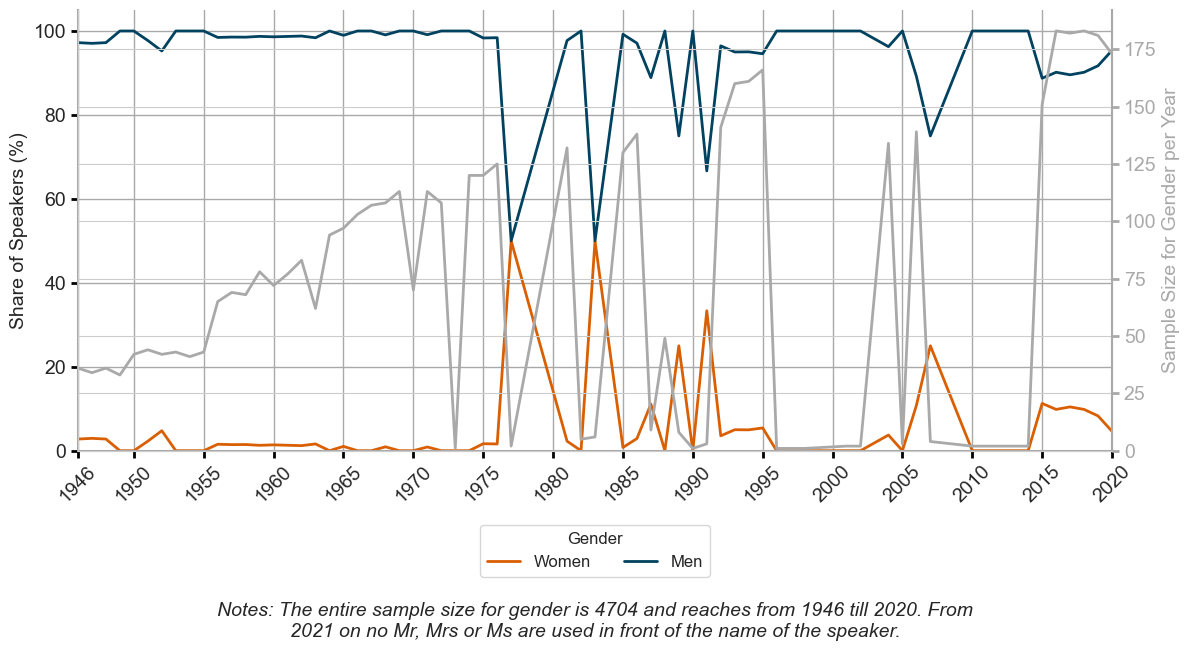

In [122]:
# === Share of Female and Male Speakers by Year ===

# Filter to only 0 and 1 (exclude NaNs)
df_gender = un_corpus_scored[un_corpus_scored['gender_dummy'].isin([0, 1])]

# Percentage share of women per year
female_percent = df_gender.groupby('year')['gender_dummy'].mean() * 100

# Percentage share of men per year
male_percent = 100 - female_percent

# Sample size per year
gender_sample_size_per_year = df_gender.groupby('year')['gender_dummy'].count()

# Total sample size included in the plot
gender_total = gender_sample_size_per_year.sum()


# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=FIGSIZE)

x = female_percent.index
female_y = female_percent.values
male_y = male_percent.values

# === Plot Female Share ===
ax1.plot(
    x, female_y,
    color=CUSTOM_COLORS[4],
    linewidth=LINEWIDTH,
    label="Women"
)

# === Plot Male Share ===
ax1.plot(
    x, male_y,
    color=CUSTOM_COLORS[0],
    linewidth=LINEWIDTH,
    label="Men"
)

# === Axis Labels ===
ax1.set_xlabel("")
ax1.set_ylabel("Share of Speakers (%)", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(bottom=AX_SET_YLIM)
ax1.margins(y=AX_SET_Y_MARGIN)

# === X-Axis Settings ===
ax1.set_xlim(1946, 2020)
tick_years = [1946] + list(range(1950, 2021, 5))
if 2020 not in tick_years:
    tick_years.append(2020)

ax1.set_xticks(tick_years)
ax1.set_xticklabels(tick_years, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

# === Tick Parameters ===
ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)

# === Spines (Left Axis) ===
ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# === Grid Lines ===
ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

# --- Right y-axis: Sample size per year ---
ax2 = ax1.twinx()
x2 = gender_sample_size_per_year.index
y2 = gender_sample_size_per_year.values

ax2.plot(
    x2, y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    label="Sample Size"
)

ax2.set_ylabel("Sample Size for Gender per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y', colors='darkgrey', direction=TICK_DIRECTION,
    length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

# === Despine & Layout ===
sns.despine(left=False, right=False, top=True, bottom=False)

# === LEGEND ===
lines_left, labels_left = ax1.get_legend_handles_labels()
lines_right, labels_right = ax2.get_legend_handles_labels()
ax1.legend(
    title="Gender",
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    fontsize=LEGEND_FONT_SIZE,
    title_fontsize=LEGEND_FONT_SIZE
)

# === Note below the plot ===
note_text = (
    f"Notes: The entire sample size for gender is {gender_total} and reaches from 1946 till 2020. "
    f"From 2021 on no Mr, Mrs or Ms are used in front of the name of the speaker."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

# === Save & Show ===
plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'share_female_male_speakers_by_year.png'), bbox_inches='tight')
plt.show()


### Figure: Share of position by speakers

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

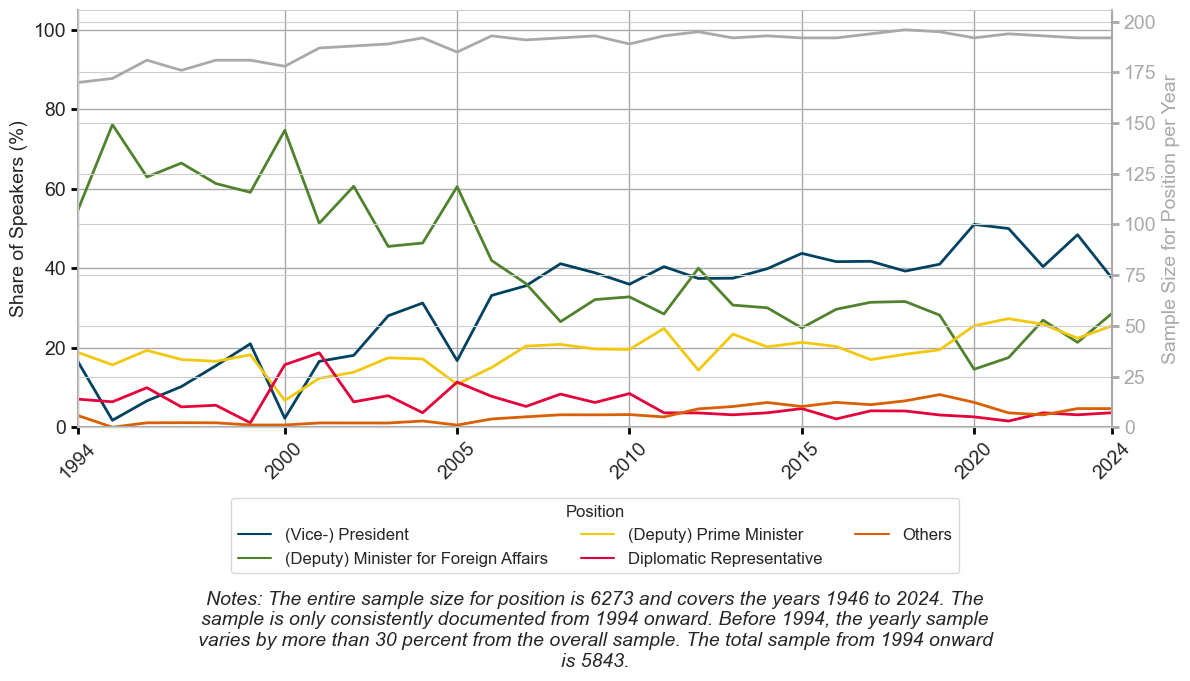

In [126]:
merge_to_others = ["Head of State", "Monarch", "Head of Government"]
un_corpus_scored["position"] = un_corpus_scored["position"].replace(merge_to_others, "Others")

# Counts per year and position
position_counts = (
    un_corpus_scored.groupby(['year', 'position'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Sample size per year (positions subset)
position_sample_size_per_year = position_counts.sum(axis=1)
position_total = position_sample_size_per_year.sum()

# Percentages per year per position
top_positions = [
    '(Vice-) President', 
    '(Deputy) Minister for Foreign Affairs',
    '(Deputy) Prime Minister', 
    'Diplomatic Representative', 
    'Others'
]

position_percentage = (
    position_counts[top_positions]
    .div(position_counts.sum(axis=1), axis=0)
    .fillna(0) * 100
)

position_percentage_long = (
    position_percentage
    .reset_index()
    .melt(id_vars="year", var_name="position", value_name="percentage")
)

fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    data=position_percentage_long,
    x="year",
    y="percentage",
    hue="position",
    palette=CUSTOM_COLORS,
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_ylabel("Share of Speakers (%)", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_xlabel("")

ax1.tick_params(
    axis='y',
    direction=TICK_DIRECTION,
    length=TICK_LENGTH,
    width=TICK_WIDTH,
    color=TICK_COLOR,
    labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    direction=TICK_DIRECTION,
    length=TICK_LENGTH,
    width=TICK_WIDTH,
    color=TICK_COLOR,
    labelsize=TICK_LABEL_FONT_SIZE
)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
sns.despine(left=False, right=False, top=True, bottom=False)

ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
sns.lineplot(
    x=position_sample_size_per_year.index,
    y=position_sample_size_per_year.values,
    color="darkgrey",
    linewidth=LINEWIDTH,
    ax=ax2
)

ax2.set_ylabel("Sample Size for Position per Year", color="darkgrey", fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y',
    colors='darkgrey',
    direction=TICK_DIRECTION,
    length=TICK_LENGTH,
    width=TICK_WIDTH,
    labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=0)

ax1.set_xlim(1994, 2024)
xtick_years = [2000, 1994] + list(range(2000, 2025, 5))
xtick_years = sorted(set(xtick_years + [2024]))
ax1.set_xticks(xtick_years)
ax1.set_xticklabels(xtick_years, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.legend(
    title="Position",
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    fontsize=LEGEND_FONT_SIZE,
    title_fontsize=LEGEND_FONT_SIZE
)

position_total_1994 = position_sample_size_per_year.loc[1994:].sum()


note_text = (
    f"Notes: The entire sample size for position is {position_total} and covers the years 1946 to 2024. "
    f"The sample is only consistently documented from 1994 onward. Before 1994, the yearly sample varies "
    f"by more than 30 percent from the overall sample. The total sample from 1994 onward is {position_total_1994}."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))
plt.figtext(0.5, -0.12, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'share_speaker_positions_by_year_representative_part.png'), bbox_inches='tight')
plt.show()

### Figure: Emotionality over time

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

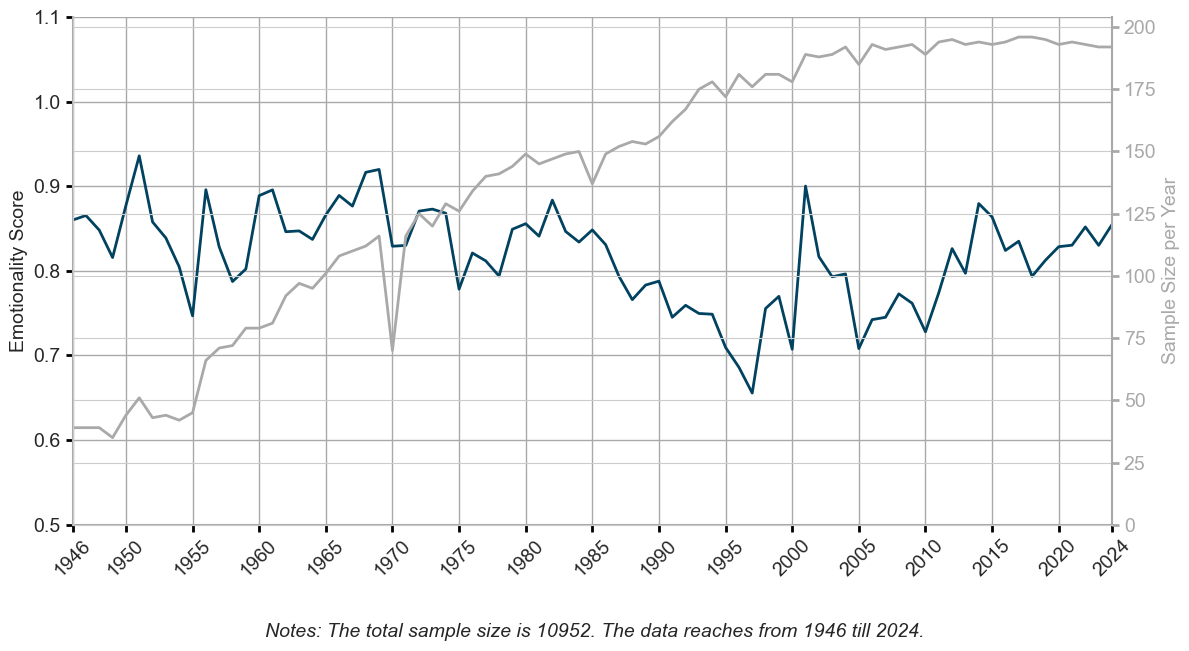

In [134]:
# Mean score per year
score_over_time = un_corpus_scored.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

x = score_over_time.index
y = score_over_time.values

sns.lineplot(
    x=x,
    y=y,
    marker=MARKER,
    color=CUSTOM_COLORS[0],
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(Y_RANGE_EMOTIONALITY)
ax1.margins(y=AX_SET_Y_MARGIN)

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)


ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)


ax2 = ax1.twinx()
x2 = overall_sample_size_per_year.index
y2 = overall_sample_size_per_year.values

sns.lineplot(
    x=x2,
    y=y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y', colors='darkgrey', direction=TICK_DIRECTION,
    length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = (
    f"Notes: The total sample size is {overall_total}. The data reaches from 1946 till 2024."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time.png'), bbox_inches='tight')
plt.show()

### Figure: Emotionality by permanent Security Council Membership

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

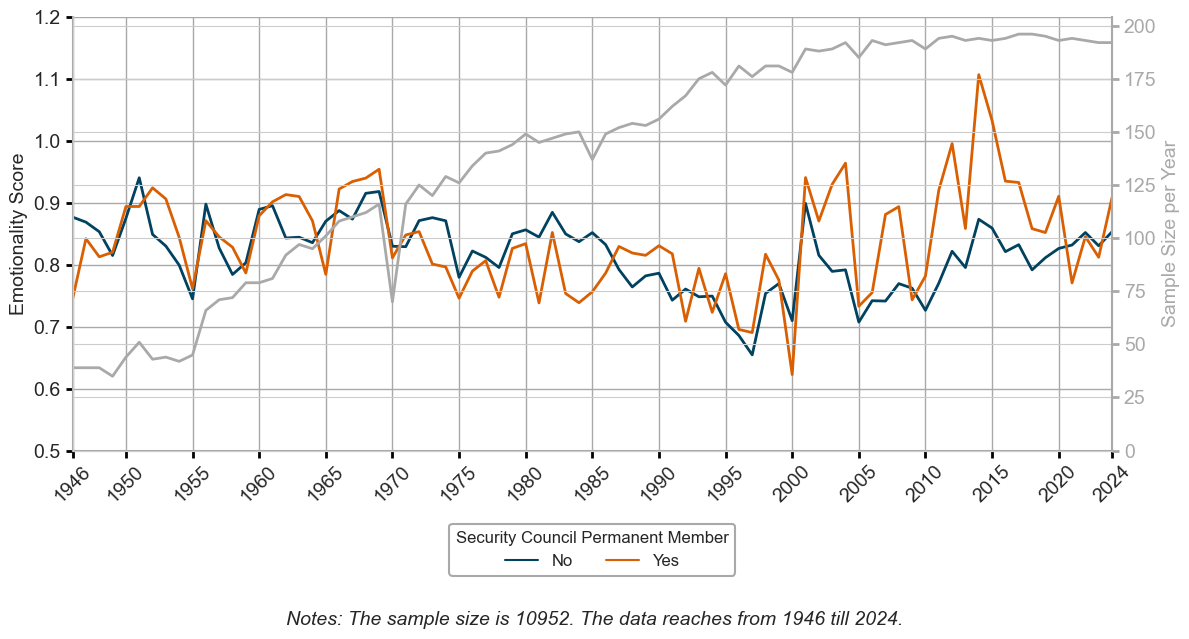

In [148]:
security_council_total = un_corpus_scored['security_council_permanent'].notna().sum()

# Sample size per year (non-missing scores)
security_council_sample_size_per_year = (
    un_corpus_scored.groupby('year')['security_council_permanent'].count()
)

# Mean scores by year and membership
score_over_time_security_council = (
    un_corpus_scored
    .groupby(['year', 'security_council_permanent'])['score']
    .mean()
    .reset_index()
)

score_over_time_security_council['security_council_permanent_label'] = (
    score_over_time_security_council['security_council_permanent']
    .map({0: 'No', 1: 'Yes'})
)

fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    data=score_over_time_security_council,
    x='year',
    y='score',
    hue='security_council_permanent_label',
    palette={'No': CUSTOM_COLORS[0], 'Yes': CUSTOM_COLORS[4]},
    linewidth=LINEWIDTH,
    marker=MARKER,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(0.5,1.2)
ax1.margins(y=AX_SET_Y_MARGIN)

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

legend = ax1.legend(
    title="Security Council Permanent Member",
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    frameon=True,
    edgecolor=SPINE_COLOR,
    facecolor='white'
)
legend.get_frame().set_linewidth(SPINE_WIDTH)
legend.get_frame().set_alpha(1)

ax2 = ax1.twinx()
x2 = security_council_sample_size_per_year.index
y2 = security_council_sample_size_per_year.values

sns.lineplot(
    x=x2,
    y=y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y', colors='darkgrey', direction=TICK_DIRECTION,
    length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = (
    f"Notes: The sample size is {security_council_total}. The data reaches from 1946 till 2024."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.05, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(
    os.path.join(fig_dir, 'emotionality_score_over_time_security_council_membership.png'),
    bbox_inches='tight'
)
plt.show()

### Figure: Emotionality for permanent members of the security council

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

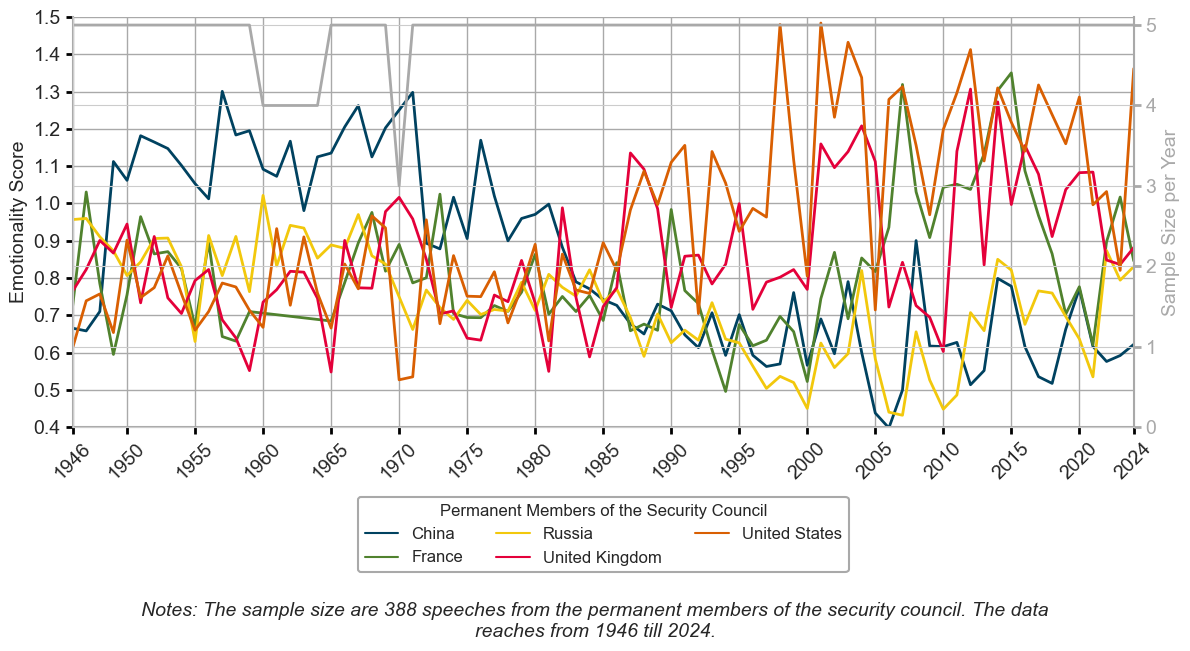

In [166]:
# Filter only Security Council permanent members
permanent_members = un_corpus_scored[un_corpus_scored['security_council_permanent'] == 1]

# Total sample size
permanent_members_total = permanent_members[['score', 'country_name']].dropna().shape[0]

# Sample size per year
permanent_members_sample_size_per_year = permanent_members.groupby('year')['security_council_permanent'].count()

# Mean scores by year and country_name
score_over_time_permanent_members = (
    permanent_members
    .groupby(['year', 'country_name'])['score']
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    data=score_over_time_permanent_members,
    x='year',
    y='score',
    hue='country_name',
    palette=CUSTOM_COLORS,
    linewidth=2,
    ax=ax1
)

ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_xlabel("")
ax1.set_ylim(0.4, 1.5)  # manually set as requested
ax1.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

# Tick styling
ax1.tick_params(axis='y', which='both', left=True, right=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)
ax1.tick_params(axis='x', which='both', bottom=True, top=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

ax2 = ax1.twinx()
x2, y2 = permanent_members_sample_size_per_year.index, permanent_members_sample_size_per_year.values
sns.lineplot(x=x2, y=y2, color='darkgrey', linewidth=LINEWIDTH, ax=ax2)

ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', colors='darkgrey', direction=TICK_DIRECTION,
                length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

legend = ax1.legend(
    title="Permanent Members of the Security Council",
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    frameon=True,
    edgecolor=SPINE_COLOR,
    facecolor='white'
)
legend.get_frame().set_linewidth(SPINE_WIDTH)
legend.get_frame().set_alpha(1)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = f"Notes: The sample size are {permanent_members_total} speeches from the permanent members of the security council. The data reaches from 1946 till 2024."
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_permanent_members.png'), bbox_inches='tight')
plt.show()


### Figure: Emotionality  by Gender

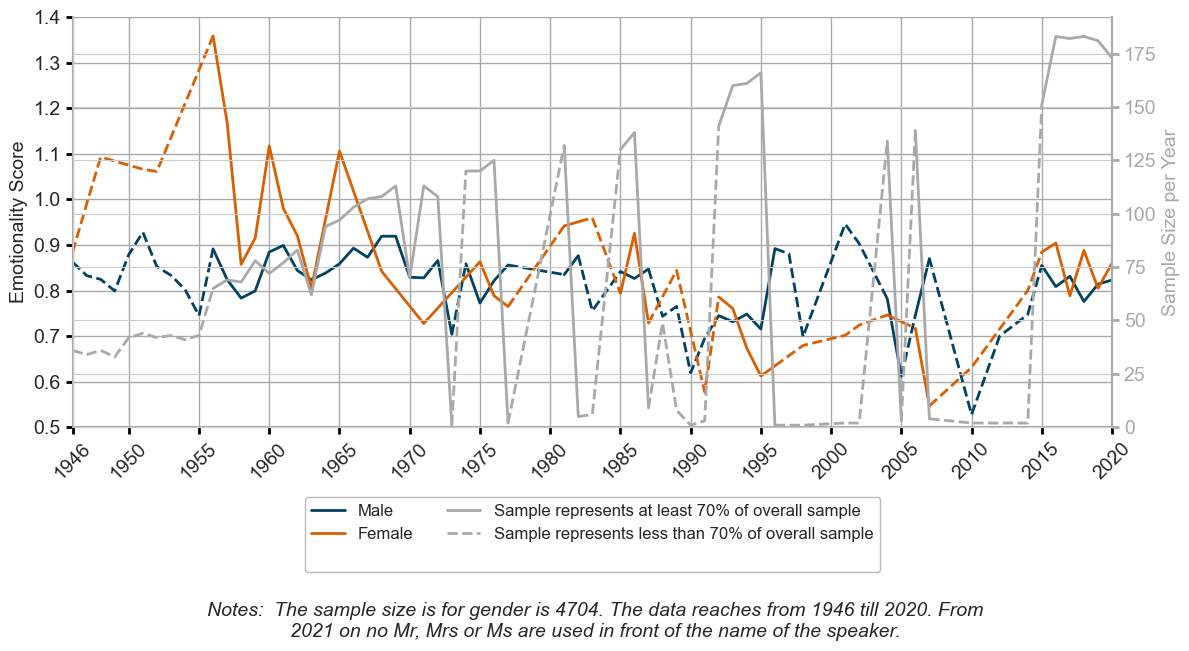

In [158]:
score_over_time_gender = (
    un_corpus_scored
    .groupby(['year', 'gender_dummy'])['score']
    .mean()
    .reset_index()
)
score_over_time_gender['gender_label'] = score_over_time_gender['gender_dummy'].map({0: 'Male', 1: 'Female'})
x_vals = gender_sample_size_per_year.index

male_scores = (
    score_over_time_gender[score_over_time_gender['gender_label']=='Male']
    .set_index('year')['score']
    .reindex(x_vals)
    .interpolate()  # fill gaps for continuous lines
)
female_scores = (
    score_over_time_gender[score_over_time_gender['gender_label']=='Female']
    .set_index('year')['score']
    .reindex(x_vals)
    .interpolate()
)
ref = gender_sample_size_per_year.reindex(x_vals).fillna(0).values

threshold = 0.3 * overall_sample_size_per_year.max()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Conditional lines for Male/Female
plot_conditional_line(ax1, x_vals, male_scores.values, reference=ref, threshold=threshold, color=CUSTOM_COLORS[0])
plot_conditional_line(ax1, x_vals, female_scores.values, reference=ref, threshold=threshold, color=CUSTOM_COLORS[4])

# Axes labels, limits, ticks, grids, spines
ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(0.5,1.4)
ax1.set_xlim(1946, 2020)
# Manually define ticks only for this plot
tick_years = [1946] + list(range(1950, 2020, 5))
if 2020 not in tick_years:
    tick_years.append(2020)

ax1.set_xticks(tick_years)
ax1.set_xticklabels(tick_years, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)
ax1.tick_params(axis='y', which='both', left=True, right=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)
ax1.tick_params(axis='x', which='both', bottom=True, top=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)
ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)


ax2 = ax1.twinx()
plot_conditional_line(ax2, x_vals, ref, reference=ref, threshold=threshold, color='darkgrey', linewidth=LINEWIDTH)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', colors='darkgrey', direction=TICK_DIRECTION,
                length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

sns.despine(left=False, right=False, top=True, bottom=False)

legend_handles = [
    Line2D([0], [0], color=CUSTOM_COLORS[0], lw=LINEWIDTH, label='Male'),
    Line2D([0], [0], color=CUSTOM_COLORS[4], lw=LINEWIDTH, label='Female'),
    Line2D([0], [0], color='white', lw=0, label=''), 

    Line2D([0], [0], color='darkgrey', lw=LINEWIDTH, linestyle='-', 
           label='Sample represents at least 70% of overall sample'),
    Line2D([0], [0], color='darkgrey', lw=LINEWIDTH, linestyle='--', 
           label='Sample represents less than 70% of overall sample')
]

ax1.legend(
    handles=legend_handles,
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=2,
    frameon=True,
    edgecolor=SPINE_COLOR,
    facecolor='white'
)

note_text = (
    f"Notes:  The sample size is for gender is {gender_total}. The data reaches from 1946 till 2020. "
    f"From 2021 on no Mr, Mrs or Ms are used in front of the name of the speaker."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=90))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_gender.png'), bbox_inches='tight')
plt.show()

### Figure: Emotionality by english as official language

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

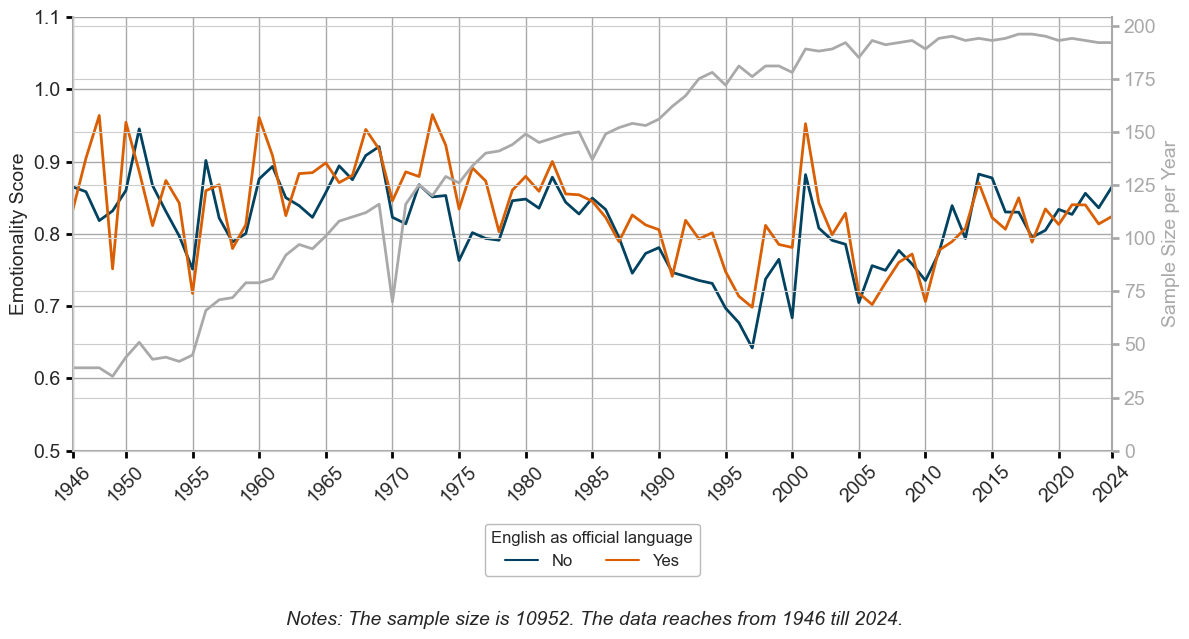

In [160]:
score_over_time_official_language = (
    un_corpus_scored
    .groupby(['year', 'english_official_language'])['score']
    .mean()
    .reset_index()
)
score_over_time_official_language['english_label'] = score_over_time_official_language['english_official_language'].map({0: 'No', 1: 'Yes'})

# PLot
fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    data=score_over_time_official_language,
    x='year',
    y='score',
    hue='english_label',
    palette={'No': CUSTOM_COLORS[0], 'Yes': CUSTOM_COLORS[4]},
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(Y_RANGE_EMOTIONALITY)
ax1.margins(y=AX_SET_Y_MARGIN)
ax1.set_xlim(1946, 2024)

tick_years_plot = [1946] + list(range(1950, 2025, 5))
if 2024 not in tick_years_plot:
    tick_years_plot.append(2024)

ax1.set_xticks(tick_years_plot)
ax1.set_xticklabels(tick_years_plot, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(axis='y', which='both', left=True, right=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)
ax1.tick_params(axis='x', which='both', bottom=True, top=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

ax2 = ax1.twinx()
x2, y2 = official_language_sample_size_per_year.index, official_language_sample_size_per_year.values
sns.lineplot(
    x=x2,
    y=y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)

ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', colors='darkgrey', direction=TICK_DIRECTION,
                length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

ax1.legend(
    title="English as official language",
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    frameon=True,
    edgecolor=SPINE_COLOR,
    facecolor='white'
)

note_text = (
    f"Notes: The sample size is {overall_total}. The data reaches from 1946 till 2024."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.05, wrapped_text, **FIG_NOTE_FONT)

sns.despine(left=False, right=False, top=True, bottom=False)
plt.tight_layout(rect=TIGHT_LAYOUT_RECT)

plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_english_official_language.png'), bbox_inches='tight')
plt.show()

### Figure: Emotionality by Speaker Position

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wil

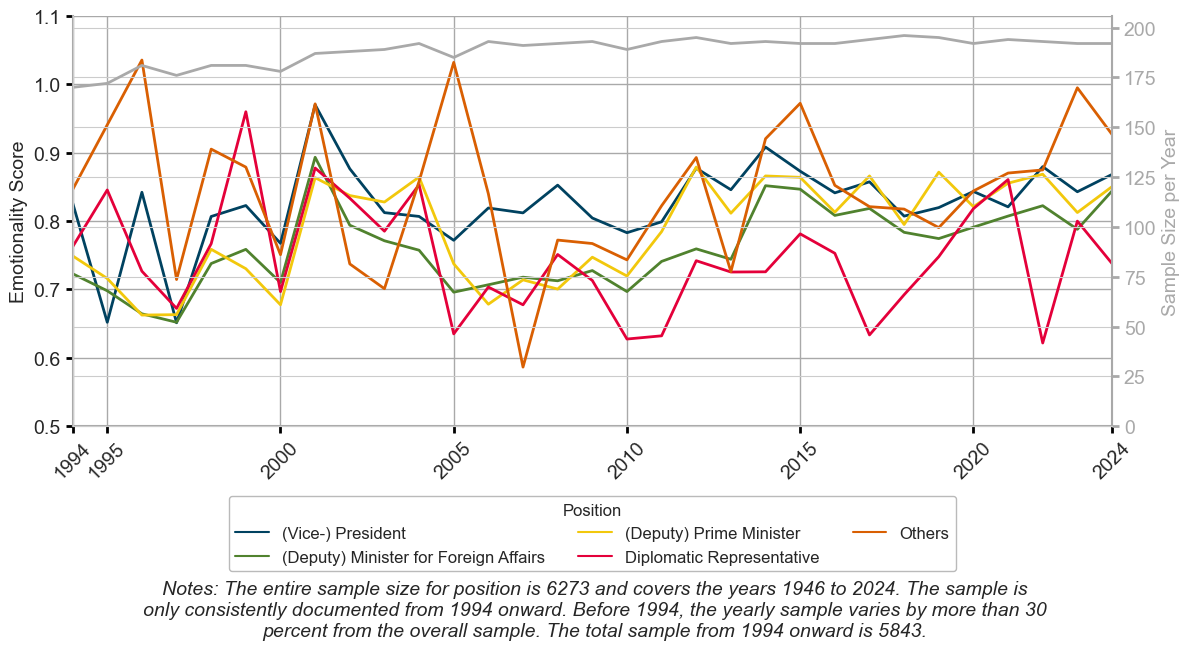

In [162]:
score_over_time_position = (
    un_corpus_scored
    .groupby(['year', 'position'])['score']
    .mean()
    .reset_index()
)

# Set the position order
score_over_time_position['position'] = pd.Categorical(
    score_over_time_position['position'],
    categories=top_positions,
    ordered=True
)


#score_over_time_position['position'] = score_over_time_position['position'].astype(str)

position_sample_size_per_year = (
    un_corpus_scored.groupby('year')['position'].count()
)

position_total = position_sample_size_per_year.sum()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

sns.lineplot(
    data=score_over_time_position,
    x='year',
    y='score',
    hue='position',
    palette=CUSTOM_COLORS,
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(Y_RANGE_EMOTIONALITY)
ax1.margins(y=AX_SET_Y_MARGIN)
ax1.set_xlim(1994, 2024)

tick_years_position = [1994] + list(range(1995, 2025, 5))
if 2024 not in tick_years_position:
    tick_years_position.append(2024)
ax1.set_xticks(tick_years_position)
ax1.set_xticklabels(tick_years_position, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(axis='y', which='both', left=True, right=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)
ax1.tick_params(axis='x', which='both', bottom=True, top=False,
                direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
                color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE)

ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)

ax2 = ax1.twinx()
sns.lineplot(
    x=position_sample_size_per_year.index,
    y=position_sample_size_per_year.values,
    color='darkgrey',
    linewidth=LINEWIDTH,  
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(axis='y', colors='darkgrey', direction=TICK_DIRECTION,
                length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

ax1.legend(
    title="Position",
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    ncol=LEGEND_NCOL,
    frameon=True,
    edgecolor=SPINE_COLOR,
    facecolor='white'
)

note_text = (
    f"Notes: The entire sample size for position is {position_total} and covers the years 1946 to 2024. "
    f"The sample is only consistently documented from 1994 onward. Before 1994, the yearly sample varies "
    f"by more than 30 percent from the overall sample. The total sample from 1994 onward is {position_total_1994}."
)

wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

sns.despine(left=False, right=False, top=True, bottom=False)
plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_position.png'), bbox_inches='tight')
plt.show()

### Cosine Similiarty of Words to the Centroids

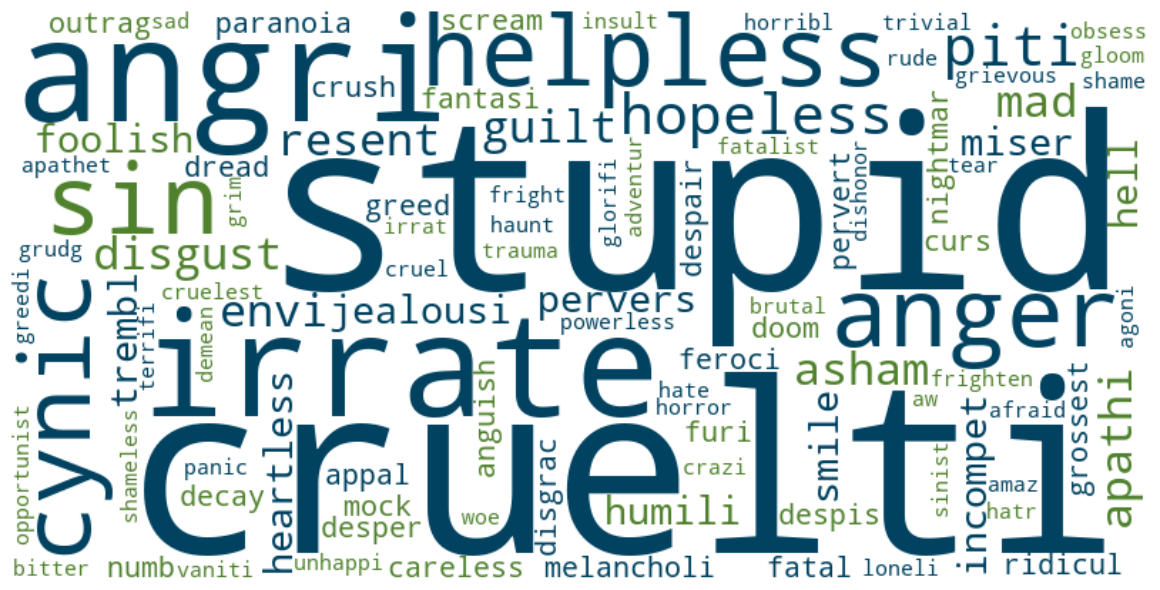

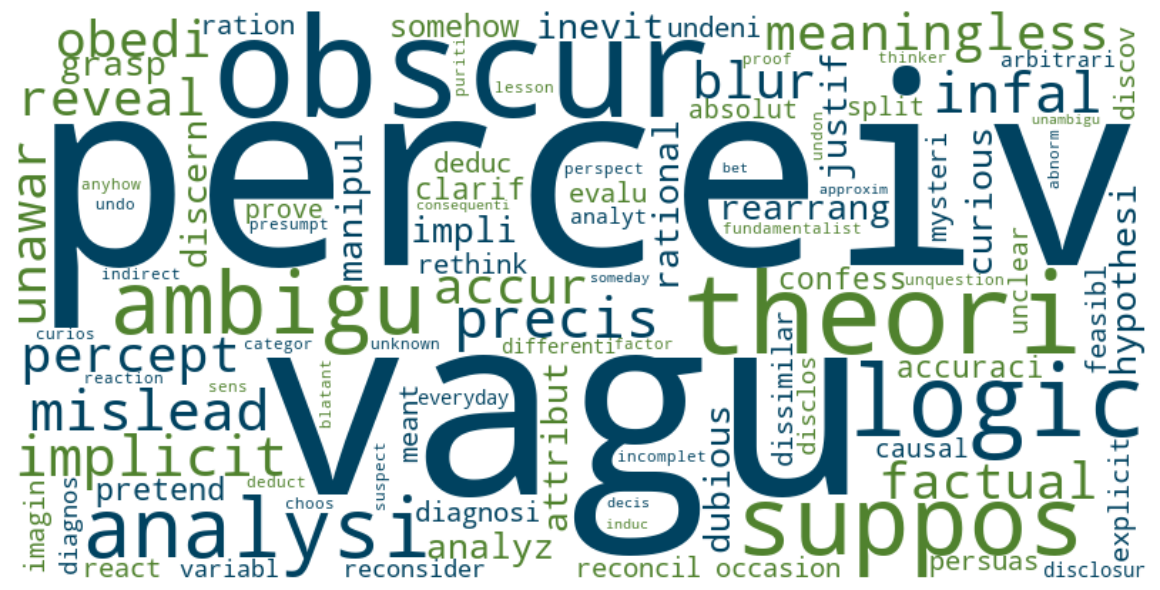

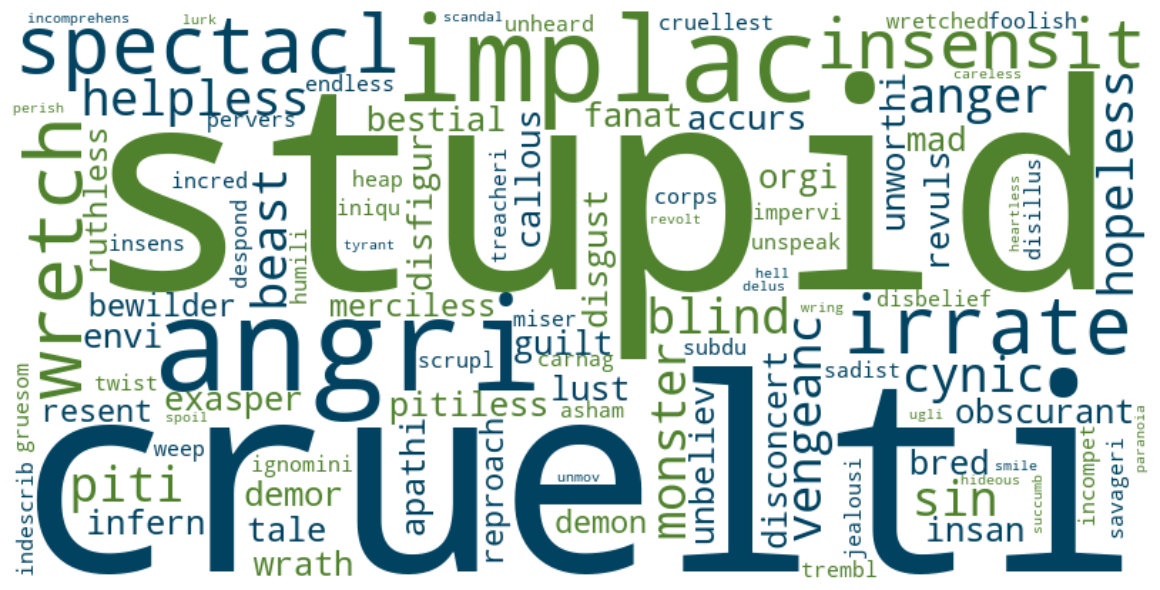

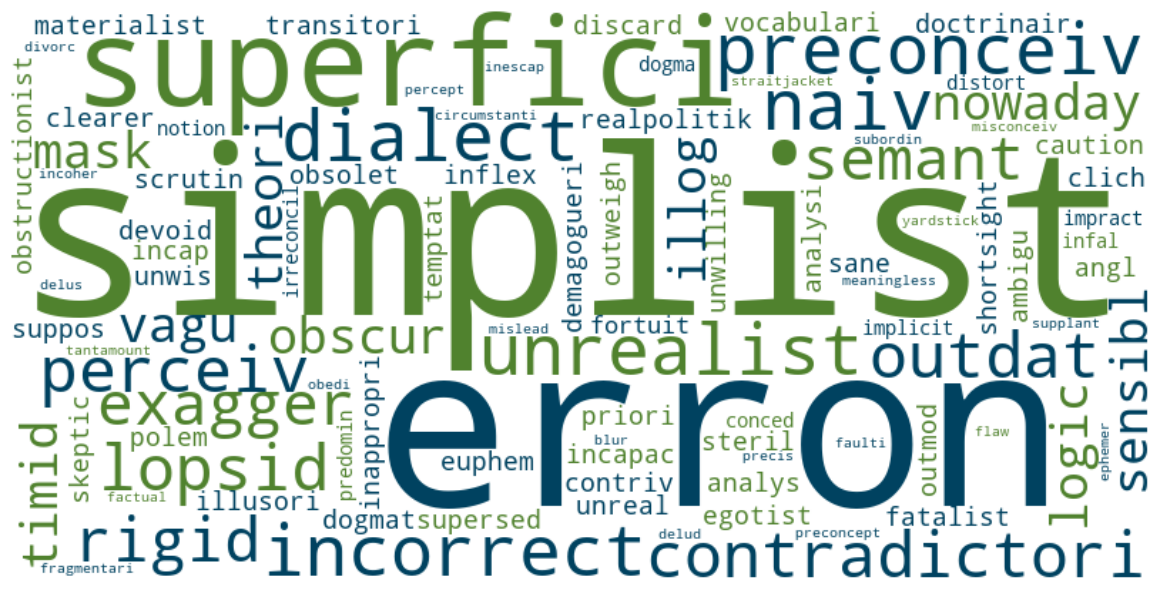

In [136]:
def word_similarity_to_centroid(word_list, centroid, model):
    similarities = {}
    for word in word_list:
        if word in model.wv:
            word_vec = model.wv[word]
            sim = 1 - cosine(word_vec, centroid)  # similarity = 1 - cosine distance
            similarities[word] = sim
    return similarities

# Cosine Similarity of affect dictionary to affect centroid
affect_dict_sim = word_similarity_to_centroid(affect_dic, affect_centroid, w2v)

# Cosine Similarity of cognition dictionary to cognition centroid
cognition_dict_sim = word_similarity_to_centroid(cognition_dic, cognition_centroid, w2v)

# Cosine Similarity of corpus words to affect centroid
corpus_words_sim_affect = word_similarity_to_centroid(corpus_words, affect_centroid, w2v)

# Cosine Similarity of corpus words to cognition centroid
corpus_words_sim_cognition = word_similarity_to_centroid(corpus_words, cognition_centroid, w2v)


def plot_wordcloud_from_sim(sim_dict, filename, top_n=100):
    sim_sorted = dict(sorted(sim_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])

    colors_wordclouds = ['#50822E', '#004260']
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return random.choice(colors_wordclouds)

    wc = WordCloud(width=800, height=400, background_color='white', color_func=color_func)
    wc.generate_from_frequencies(sim_sorted)

    plt.figure(figsize=FIGSIZE)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, filename), bbox_inches='tight')
    plt.show()
#  Wordcloud highest cosine similarity of affect dictionary to affect centroid
plot_wordcloud_from_sim(affect_dict_sim, "affect_dict_wordcloud.png")

# Wordcloud highest cosine similarity of cognition dictionary to cognition centroid
plot_wordcloud_from_sim(cognition_dict_sim, "cognition_dict_wordcloud.png")

# Wordcloud highest cosine similarity of corpus words to affect centroid
plot_wordcloud_from_sim(corpus_words_sim_affect, "corpus_affect_wordcloud.png")

# Wordcloud highest cosine similarity of corpus words to cognition centroid
plot_wordcloud_from_sim(corpus_words_sim_cognition, "corpus_cognition_wordcloud.png")

## Additional Figures: Emotionality when adjusting stopwords or removing lower frequency words

### Figure: Emotionality over time (Individual Stopwords List)

C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

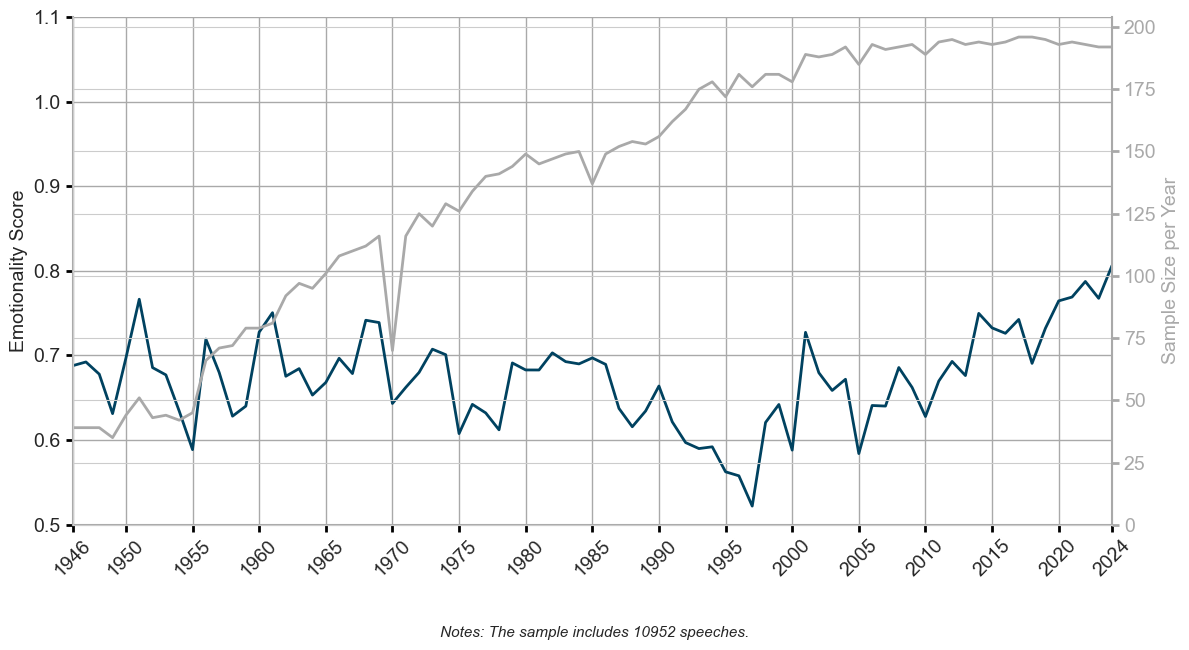

In [210]:
# Mean score per year
score_over_time = ind_stopwords_un_corpus_scored.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

x = score_over_time.index
y = score_over_time.values

sns.lineplot(
    x=x,
    y=y,
    marker=MARKER,
    color=CUSTOM_COLORS[0],
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(Y_RANGE_EMOTIONALITY)
ax1.margins(y=AX_SET_Y_MARGIN)

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)


ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)


ax2 = ax1.twinx()
x2 = overall_sample_size_per_year.index
y2 = overall_sample_size_per_year.values

sns.lineplot(
    x=x2,
    y=y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y', colors='darkgrey', direction=TICK_DIRECTION,
    length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = (
    f"Notes: The sample includes {overall_total} speeches."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_ind_stopwords.png'), bbox_inches='tight')
plt.show()

### Figure: Emotionality over time (Excluding low frequency words for weighting)

In [4]:
# Mean score per year
score_over_time = removed_lowfreq_words_un_corpus_scored.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=FIGSIZE)

x = score_over_time.index
y = score_over_time.values

sns.lineplot(
    x=x,
    y=y,
    marker=MARKER,
    color=CUSTOM_COLORS[0],
    linewidth=LINEWIDTH,
    ax=ax1
)

ax1.set_xlabel("")
ax1.set_ylabel("Emotionality Score", fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_ylim(Y_RANGE_EMOTIONALITY)
ax1.margins(y=AX_SET_Y_MARGIN)

ax1.set_xlim(1946, 2024)
ax1.set_xticks(TICK_YEARS)
ax1.set_xticklabels(TICK_YEARS, rotation=XTICK_ROTATION, fontsize=TICK_LABEL_FONT_SIZE)

ax1.tick_params(
    axis='y', which='both', left=True, right=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)
ax1.tick_params(
    axis='x', which='both', bottom=True, top=False,
    direction=TICK_DIRECTION, length=TICK_LENGTH, width=TICK_WIDTH,
    color=TICK_COLOR, labelsize=TICK_LABEL_FONT_SIZE
)


ax1.spines['left'].set_color(SPINE_COLOR)
ax1.spines['left'].set_linewidth(SPINE_WIDTH)
ax1.spines['bottom'].set_color(SPINE_COLOR)
ax1.spines['bottom'].set_linewidth(SPINE_WIDTH)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.yaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)
ax1.xaxis.grid(True, color=GRID_COLOR, linewidth=GRID_WIDTH, zorder=0)


ax2 = ax1.twinx()
x2 = overall_sample_size_per_year.index
y2 = overall_sample_size_per_year.values

sns.lineplot(
    x=x2,
    y=y2,
    color='darkgrey',
    linewidth=LINEWIDTH,
    ax=ax2
)
ax2.set_ylabel("Sample Size per Year", color='darkgrey', fontsize=AXIS_LABEL_FONT_SIZE)
ax2.tick_params(
    axis='y', colors='darkgrey', direction=TICK_DIRECTION,
    length=TICK_LENGTH, width=TICK_WIDTH, labelsize=TICK_LABEL_FONT_SIZE
)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(SPINE_COLOR)
ax2.spines['right'].set_linewidth(SPINE_WIDTH)
ax2.set_ylim(bottom=SECOND_Y_AXIS_BOTTOM)

sns.despine(left=False, right=False, top=True, bottom=False)

note_text = (
    f"Notes: The sample includes {overall_total} speeches."
)
wrapped_text = "\n".join(textwrap.wrap(note_text, width=100))
plt.figtext(0.5, -0.07, wrapped_text, **FIG_NOTE_FONT)

plt.tight_layout(rect=TIGHT_LAYOUT_RECT)
plt.savefig(os.path.join(fig_dir, 'emotionality_score_over_time_removed_lowfreq_words.png'), bbox_inches='tight')
plt.show()

NameError: name 'removed_lowfreq_words_un_corpus_scored' is not defined

# Appendix

In [13]:
# Get the first and last value
pd.set_option('display.max_rows', None)
overall_sample_size_per_year

# Show only the first and last year
print(overall_sample_size_per_year.head(1))
print(overall_sample_size_per_year.tail(1))

year
1946    39
Name: count, dtype: int64
year
2024    192
Name: count, dtype: int64


In [34]:
print(f"Number of stopwords before merging: {len(stopwords)}")
print(f"Number of procedural words before merging: {len(procedural_words)}")

Number of stopwords before merging: 18997
Number of procedural words before merging: 2884


In [ ]:
# Unique Words after preprocessing
num_unique_words = len(word_counts)
print(f"Number of unique words: {num_unique_words}")

total_tokens = sum(word_counts.values())
print(f"Total number of word tokens: {total_tokens}")